# Ciclope example 01 - from CT image to voxel-FE model solution in Calculix
Created on:  23.05.2021 <br />
Last update: 04.06.2022 <br />

This example illustrates a **ciclope** pipeline for generating a voxel Finite Element model from a CT scan of trabecular bone, and solving a linear compression test using **CalculiX**. 

The pipeline can be executed from the command line using the **ciclope** with the command: <br />
```commandline
python ciclope.py input.tif output.inp -vs 0.0606 0.0606 0.0606 --smooth -r 1.2 --vol_mesh --shell_mesh --voxelfe --template ./../input_templates/tmp_example01_comp_static_bone.inp -v
```

Display the ciclope help for detailed information on command line arguments: <br />
`python ciclope.py -h`

For info on the solver see the [Calculix homepage](http://www.calculix.de/)

## Configuration

In [1]:
import sys
sys.path.append('./../')

In [2]:
import os
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
import ciclope

astropy module not found


In [3]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [4]:
%%html
<style>
table {float:left}
</style>

#### Read input data

In [5]:
input_file = '/home/gianthk/Data/2019.001.coop_TUberlin_simulierte_Mensch.iorig/trabecular_samples/trabecular_sample_mini3/2000L_crop_imgaussfilt_60micron_uint8_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Scanner|Scanco XtremeCT-II|
|Sample|human femur head|
|Voxel size|60.6 micron|
|Preliminary operations|imgaussfilt; downsampled (2X; quadratic interpolation); to uint8|

In [4]:
data_3D = read_tiff_stack(input_file)

NameError: name 'input_file' is not defined

Voxelsize

In [5]:
vs = np.ones(3)*0.0606 # [mm]

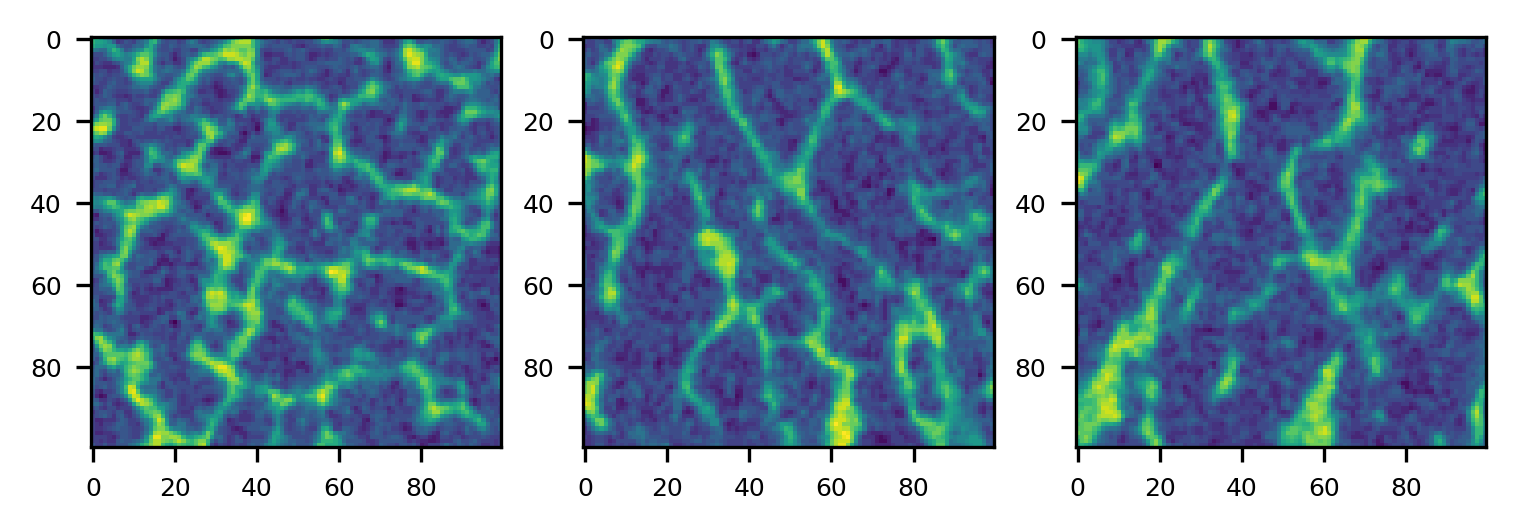

In [12]:
# Inspect dataset
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [9]:
import itk
from itkwidgets import view
viewer = view(data_3D, ui_collapsed=True)
viewer.interpolation = False

In [ ]:
# launch itk viewer
viewer

## Pre-processing
### Gaussian smooth (optional)

In [7]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (optional)

In [8]:
resampling = 1.2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

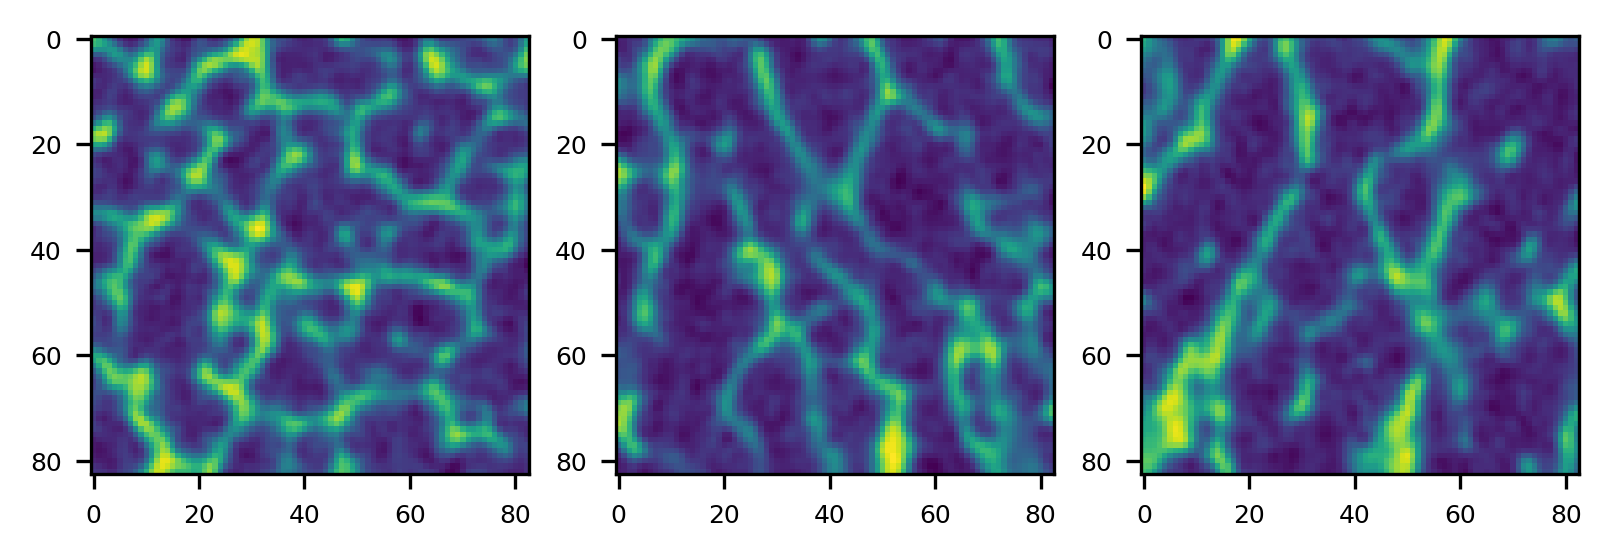

In [9]:
# Inspect dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding

In [6]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 140


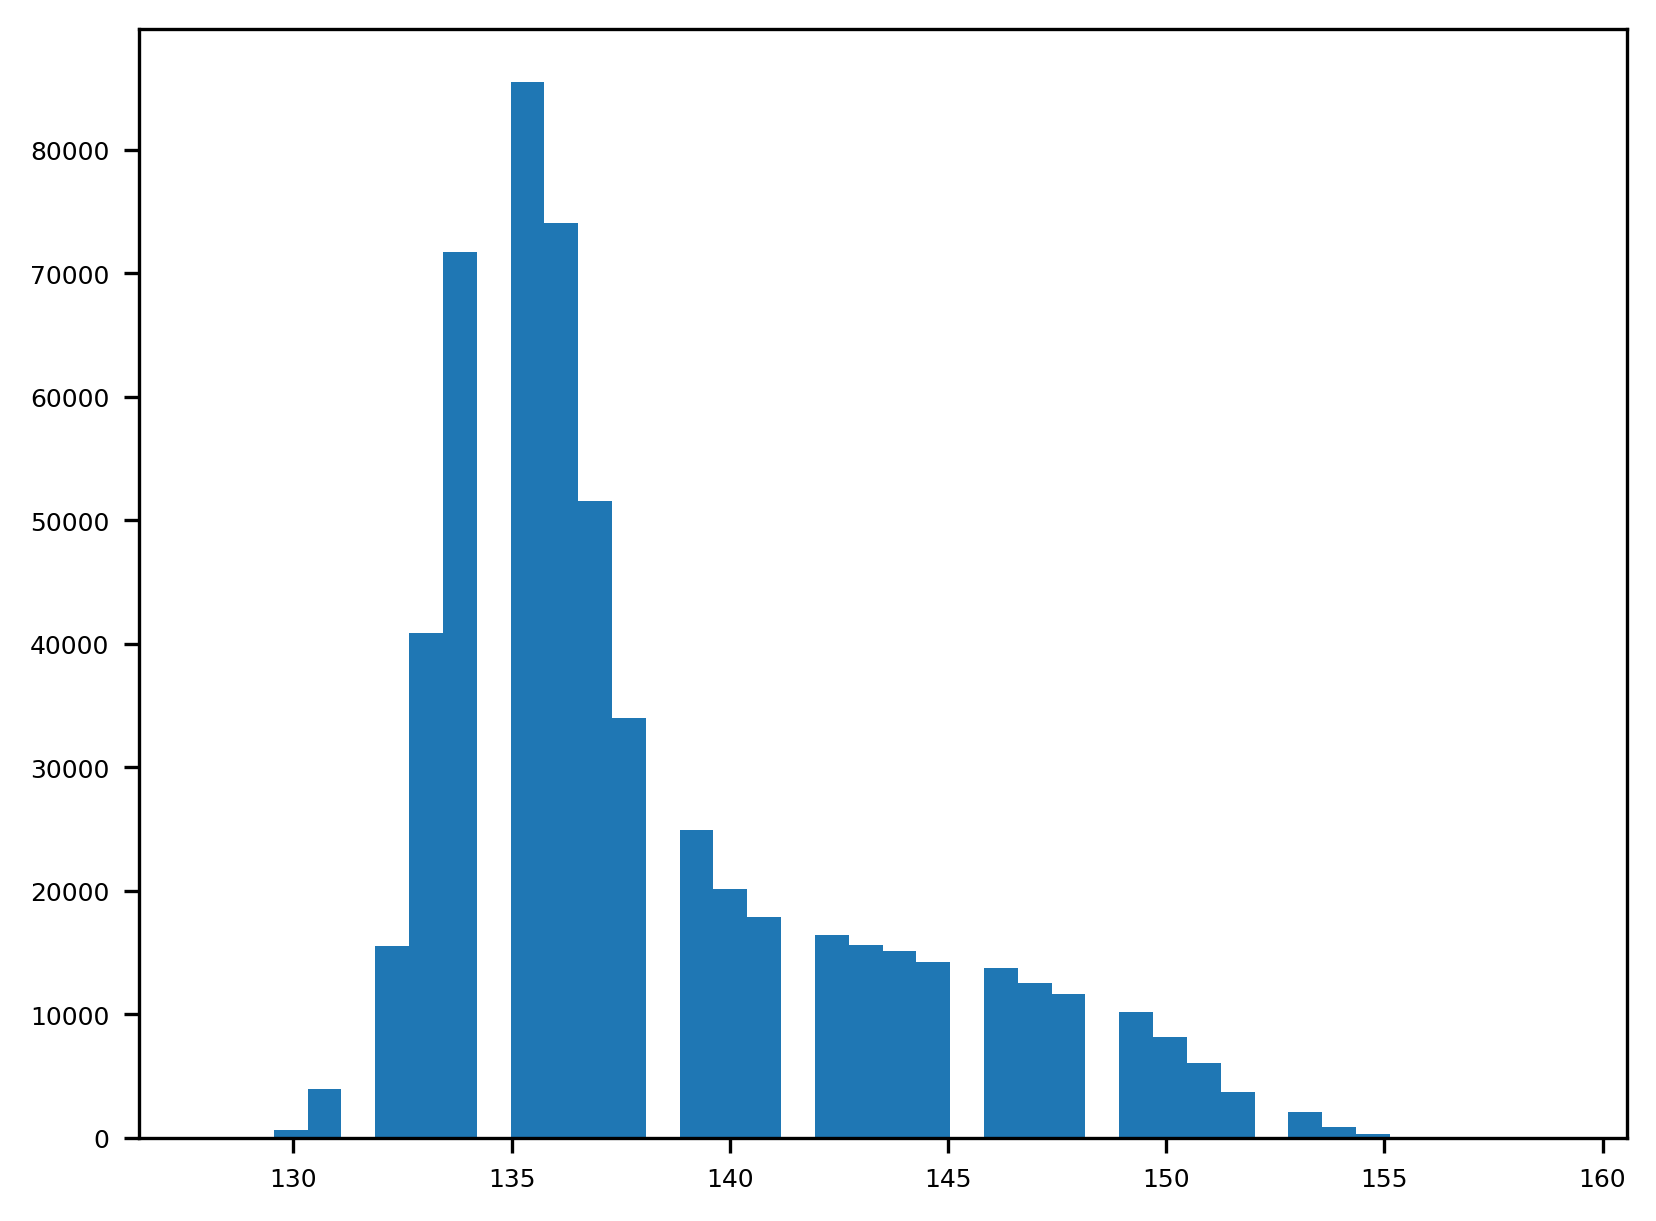

In [51]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

In [7]:
# apply the threshold
BW = data_3D > T
# BW = data_3D > 142

### Detect largest isolated cluster of voxels

Label the 3D BW image

In [12]:
# [labels, n_labels] = measure.label(BW, None, True)
[labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

Inspect the labels with [napari](https://napari.org/)

In [ ]:
import napari
viewer = napari.view_image(labels)

Count occurrences of each label and find largest connected region

In [13]:
occurrences = np.bincount(labels.reshape(labels.size))

In [14]:
largest_label_id = occurrences[1:].argmax()+1
L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in **pybonemorph**

In [8]:
from pybonemorph import remove_unconnected

In [9]:
L = remove_unconnected(BW)

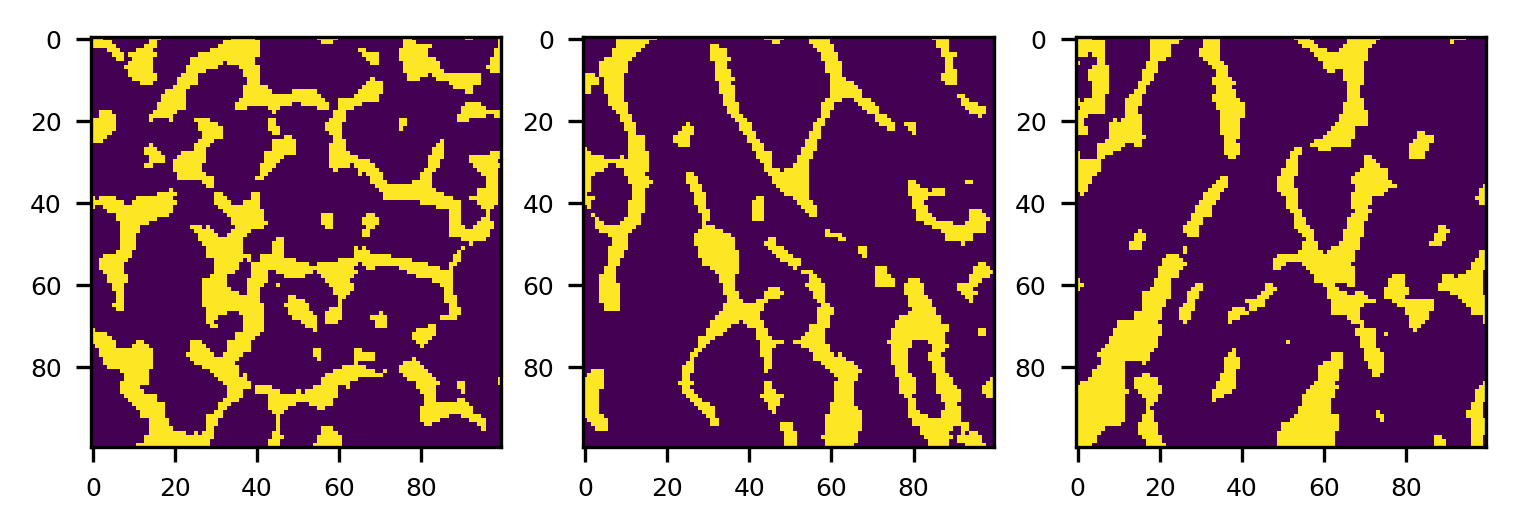

In [20]:
# Inspect dataset
# plot_midplanes(np.bitwise_xor(L, BW))
plot_midplanes(L)
plt.show()

## Generate Unstructired Grid Mesh of hexahedra from volume data

In [10]:
mesh = ciclope.voxelFE.vol2ugrid(L, vs, verbose=True)

INFO:root:Calculating cell array
INFO:root:Detecting node coordinates and boundary nodes
INFO:root:Generated the following mesh with 1030301 nodes and 259580 elements:
INFO:root:<meshio mesh object>
  Number of points: 1030301
  Number of cells:
    hexahedron: 259580
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


## Write CalculiX input FE files
### Generate voxel-FE model with constant material properties
If a binary ndarray is given as input, the script `vol2voxelfe` will assume that the material property definition is contained in the FE analysis `.INP` template file.

In [11]:
# input_template = "input_templates/tmp_example01_tens_static_bone.inp"
input_template = "./../input_templates/tmp_example01_comp_static_bone.inp"

In [12]:
filename_out = './../test_data/trabecular_bone/trabecular_sample_voxelfe.inp'

In [13]:
ciclope.voxelFE.mesh2voxelfe(mesh, input_template, filename_out, keywords=['NSET', 'ELSET'], verbose=True)

INFO:root:Found cell_data: GV. cell_data range: True - True.
INFO:root:Start writing INP file
INFO:root:Writing model nodes to INP file
INFO:root:Writing model elements to INP file
INFO:root:Additional nodes sets generated: ['NODES_Y1', 'NODES_Y0', 'NODES_X0', 'NODES_X1', 'NODES_Z1', 'NODES_Z0']
INFO:root:Additional cell sets generated: ['CELLS_Y1', 'CELLS_Y0', 'CELLS_X0', 'CELLS_X1', 'CELLS_Z1', 'CELLS_Z0']
INFO:root:Reading Abaqus template file ./../input_templates/tmp_example01_comp_static_bone.inp
INFO:root:Model with 1030301 nodes and 259580 elements written to file ./../test_data/trabecular_bone/trabecular_sample_voxelfe.inp


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`



In [263]:
# !export OMP_NUM_THREADS=8; ccx_2.17_MT "trabecular_sample_voxelfe"

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [60]:
import ccx2paraview

In [61]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

INFO:root:Reading trabecular_sample_voxelfe.frd
INFO:root:243182 nodes
INFO:root:148535 cells
INFO:root:Step 1, time 1.0, U, 3 components, 243182 values
INFO:root:Step 1, time 1.0, S, 6 components, 243182 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 243182 values
INFO:root:1 time increment
INFO:root:Writing trabecular_sample_voxelfe.vtk


INFO:root:Step 1, time 1.0, U, 3 components, 243182 values
INFO:root:Step 1, time 1.0, S, 6 components, 243182 values
INFO:root:Step 1, time 1.0, S_Mises, 1 components, 243182 values
INFO:root:Step 1, time 1.0, S_Principal, 3 components, 243182 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 243182 values


#### Visualize results in Paraview

In [65]:
!paraview filename_out_base + '.vtk'

![](./../test_data/trabecular_bone/U3.png)

Visuailzation with itkwidgtes (does not show field data..)

In [4]:
import vtk

In [5]:
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName(filename_vtk)
reader.Update()
grid = reader.GetOutput()

In [ ]:
view(geometries=grid)